<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/SPADE_timm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# =====================================================
# セル1: MVTec AD を mydrive 直リンクからダウンロード＆展開（Drive不要）
# - TARGET="all" なら全体 (~5GB)
# - それ以外はクラス名（例: "bottle"）のみをダウンロード
# - 展開先: /content/mvtec_anomaly_detection/<class>/...
# - 互換リンク: /content/mvtec -> /content/mvtec_anomaly_detection
# =====================================================

import os, subprocess, tarfile, zipfile, glob

TARGET = "bottle"  # "all" または 15クラス名のいずれか: bottle,cable,capsule,carpet,grid,hazelnut,leather,metal_nut,pill,screw,tile,toothbrush,transistor,wood,zipper
DEST_PARENT = "/content"
DEST_ROOT   = os.path.join(DEST_PARENT, "mvtec_anomaly_detection")
COMP_LINK   = "/content/mvtec"  # 互換リンク

WHOLE_URL = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz"
CLASS_URLS = {
    "bottle":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz",
    "cable":       "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937413-1629951498/cable.tar.xz",
    "capsule":     "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz",
    "carpet":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz",
    "grid":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937487-1629951814/grid.tar.xz",
    "hazelnut":    "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz",
    "leather":     "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937607-1629951964/leather.tar.xz",
    "metal_nut":   "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz",
    "pill":        "https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz",
    "screw":       "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz",
    "tile":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938133-1629953189/tile.tar.xz",
    "toothbrush":  "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938134-1629953256/toothbrush.tar.xz",
    "transistor":  "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz",
    "wood":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938383-1629953354/wood.tar.xz",
    "zipper":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938385-1629953449/zipper.tar.xz",
}
IMG_EXTS = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif','*.tiff')

def run(cmd):
    print("[RUN]", cmd)
    rc = subprocess.call(cmd, shell=True)
    if rc != 0:
        raise RuntimeError(f"Command failed (rc={rc}): {cmd}")

def list_images_multi_ext(dirpath: str):
    files=[]
    for ext in IMG_EXTS:
        files += glob.glob(os.path.join(dirpath, '**', ext), recursive=True)
    return sorted(files)

os.makedirs(DEST_ROOT, exist_ok=True)

if TARGET == "all":
    tar_path = os.path.join(DEST_PARENT, "mvtec_ad.tar.xz")
    run(f'wget --progress=dot:mega -O "{tar_path}" "{WHOLE_URL}"')
    run(f'tar -xf "{tar_path}" -C "{DEST_PARENT}"')
else:
    if TARGET not in CLASS_URLS:
        raise ValueError(f"Unknown TARGET='{TARGET}'.")
    tar_path = os.path.join(DEST_PARENT, f"{TARGET}.tar.xz")
    run(f'wget --progress=dot:mega -O "{tar_path}" "{CLASS_URLS[TARGET]}"')
    run(f'tar -xf "{tar_path}" -C "{DEST_ROOT}"')

# 互換リンク（/content/mvtec）が無ければ作成
if not os.path.exists(COMP_LINK):
    try:
        os.symlink(DEST_ROOT, COMP_LINK)
        print("[INFO] Symlink:", COMP_LINK, "->", DEST_ROOT)
    except Exception as e:
        print("[WARN] symlink failed:", e)

# 簡易チェック＆要約
def quick_summary(root_parent="/content"):
    candidates = ["/content/mvtec", "/content/mvtec_anomaly_detection"]
    ok = False
    for base in candidates:
        if not os.path.isdir(base): continue
        classes = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
        classes = sorted([c for c in classes if os.path.isdir(os.path.join(base,c,"test")) or os.path.isdir(os.path.join(base,c,"train"))])
        if not classes: continue
        print(f"[READY] Found classes under {base}: {classes[:10]}{' ...' if len(classes)>10 else ''}")
        # 1クラスだけ簡易枚数
        cls0 = classes[0]
        tg = os.path.join(base, cls0, "train", "good")
        ttg= os.path.join(base, cls0, "test",  "good")
        n_tg = len(list_images_multi_ext(tg)) if os.path.isdir(tg) else 0
        n_ttg= len(list_images_multi_ext(ttg)) if os.path.isdir(ttg) else 0
        print(f"[SUMMARY] sample class={cls0}: train/good={n_tg}, test/good={n_ttg}")
        ok = True
    if not ok:
        raise FileNotFoundError("Extraction finished but dataset layout not detected. Please check archive.")
    print("[DONE] MVTec AD is ready under /content/mvtec_anomaly_detection")

quick_summary()


[RUN] wget --progress=dot:mega -O "/content/bottle.tar.xz" "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz"
[RUN] tar -xf "/content/bottle.tar.xz" -C "/content/mvtec_anomaly_detection"
[READY] Found classes under /content/mvtec: ['bottle']
[SUMMARY] sample class=bottle: train/good=209, test/good=20
[READY] Found classes under /content/mvtec_anomaly_detection: ['bottle']
[SUMMARY] sample class=bottle: train/good=209, test/good=20
[DONE] MVTec AD is ready under /content/mvtec_anomaly_detection


[SUMMARY] {'root': '/content/mvtec', 'class': 'bottle', 'train/good': 209, 'test/good': 20, 'test/anoms': 63, 'anomaly_types': ['contamination', 'broken_large', 'broken_small']}
[INFO] train=189 | val=20 | test=83
[MEM] descriptors: (80000, 384)
[TAU] from val 99.5% → tau=0.258740
[IMAGE] AUROC=1.0000 | AP=1.0000


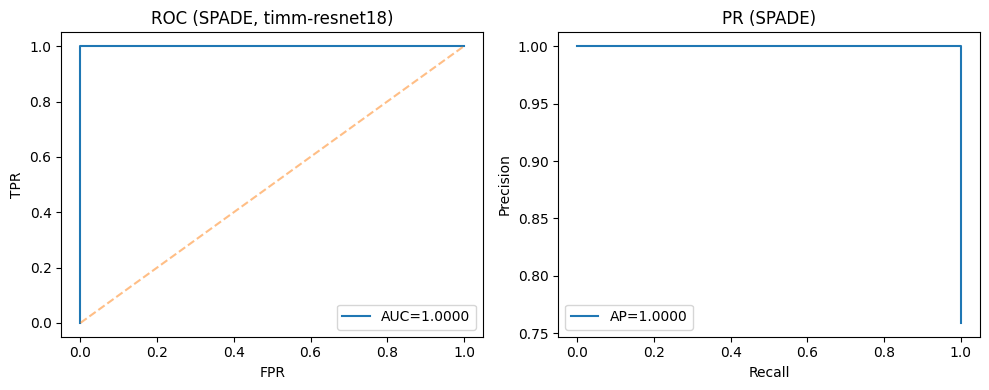

[SHOW] Top-6 anomaly candidates


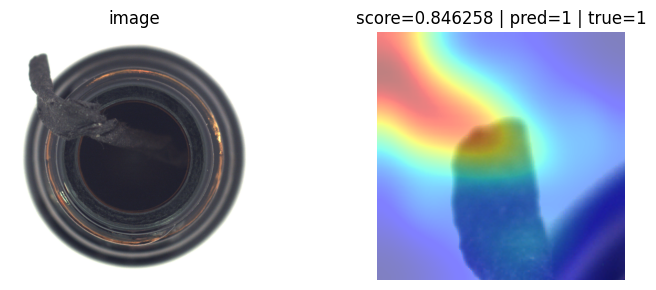

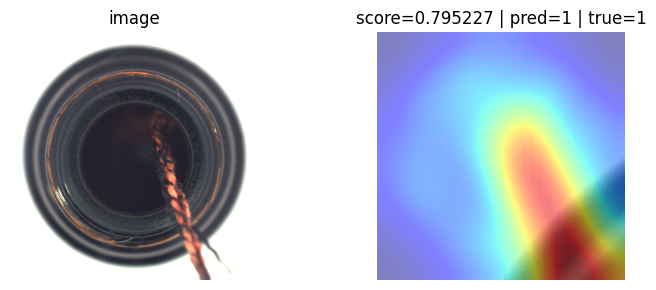

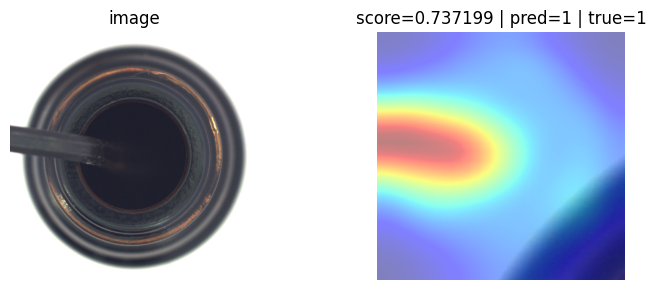

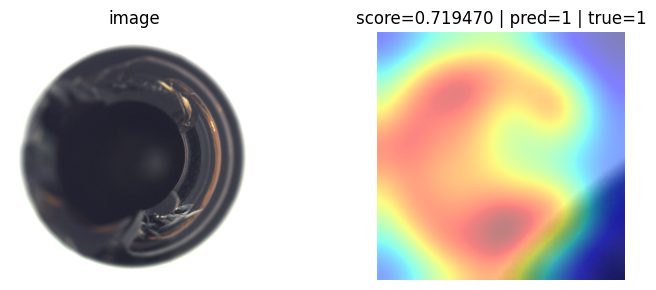

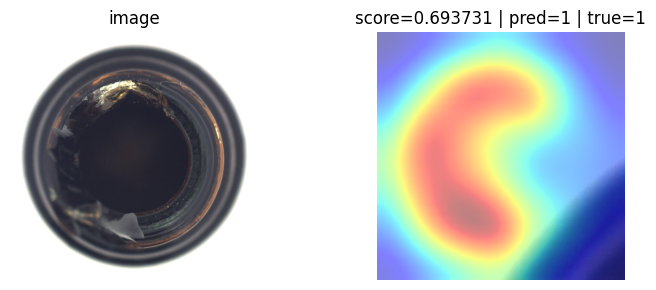

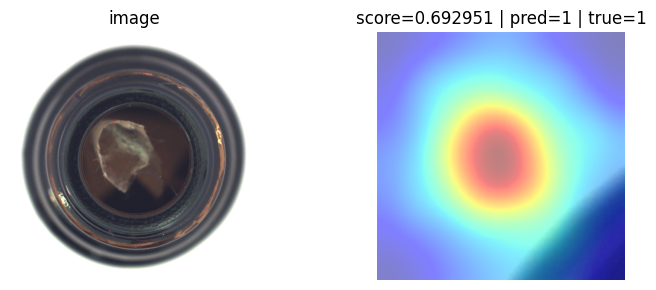

[CONF] TP=63 FP=1 FN=0 TN=19
[SHOW] False Positive examples


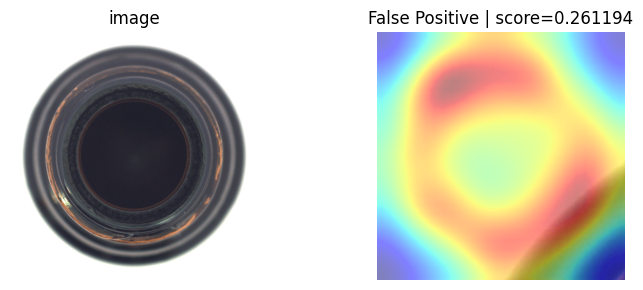

[SHOW] False Negative: none
[SAVED] /content/out_spade_timm/scores_bottle.npy, labels_bottle.npy


In [8]:
# ============================================================
# セル2: SPADE (Sub-Image Anomaly Detection) with timm (ResNet18)
# - MVTec AD: /content/mvtec_anomaly_detection/<class>/...
# - 特徴: layer2 + layer3 をチャネル結合（Early fusion）
# - kNN: sklearn NearestNeighbors (euclidean, 1-NN)
# - 画像スコア: 上位 p% 平均
# - 閾値: train/good を split した val の分位点
# ============================================================

import os, glob, math, random
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc
from scipy.ndimage import gaussian_filter

# ---------------- Config ----------------
# セル1の TARGET に合わせる（必要なら手で変更）
CLASS_NAME       = globals().get("TARGET", "bottle")
ROOT_CANDIDATES  = ["/content/mvtec", "/content/mvtec_anomaly_detection"]

# 画像前処理（timm/ResNet18の標準）
IMG_SIZE         = 256
CROP_SIZE        = 224
MEAN             = [0.485, 0.456, 0.406]
STD              = [0.229, 0.224, 0.225]

BATCH            = 16
VAL_SPLIT        = 0.10         # train/good のうち val 用割合
FEAT_INDICES     = (2, 3)       # timm ResNet18: (layer2, layer3)
TOP_P            = 0.02         # 画像スコア＝上位p%の平均
BLUR_SIGMA       = 2.0          # ヒートマップ平滑化 (None/0 で無効)
MAX_TRAIN_DESCS  = 80000        # メモリ節約で間引き
SAVE_DIR         = "/content/out_spade_timm"

SEED             = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(SAVE_DIR, exist_ok=True)
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
torch.set_grad_enabled(False)

# ---------------- Utility ----------------
IMG_EXTS = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")
def list_images_multi_ext(dirp):
    files=[]
    for r,_,fs in os.walk(dirp):
        for f in fs:
            if os.path.splitext(f)[1].lower() in IMG_EXTS:
                files.append(os.path.join(r,f))
    return sorted(files)

def autodetect_root(cls: str):
    hits=[]
    for base in ROOT_CANDIDATES:
        p_tr = os.path.join(base, cls, "train", "good")
        p_te = os.path.join(base, cls, "test")
        if os.path.isdir(p_tr) and os.path.isdir(p_te):
            hits.append(base)
    if not hits:
        # 深掘り
        for base in ["/content"]:
            for p in glob.glob(os.path.join(base, "**", cls, "train", "good"), recursive=True):
                root = p.split(f"/{cls}/train/")[0]
                if os.path.isdir(os.path.join(root, cls, "test")):
                    hits.append(root)
    if not hits:
        raise FileNotFoundError(f"[ERROR] Dataset for class='{cls}' not found under /content.")
    hits = sorted(set(hits), key=lambda x: len(x))
    return hits[0]

def print_dataset_summary(root, cls):
    tg  = os.path.join(root, cls, "train", "good")
    ttg = os.path.join(root, cls, "test", "good")
    tdir= os.path.join(root, cls, "test")
    def _c(p): return len(list_images_multi_ext(p)) if os.path.isdir(p) else 0
    subs=[]
    if os.path.isdir(tdir):
        subs=[d for d in os.listdir(tdir) if os.path.isdir(os.path.join(tdir,d)) and d not in ["good","ground_truth"]]
    n_an=0
    for d in subs: n_an += _c(os.path.join(tdir,d))
    print("[SUMMARY]", {"root":root, "class":cls, "train/good":_c(tg),
                        "test/good":_c(ttg), "test/anoms":n_an, "anomaly_types":subs})

# ---------------- Datasets ----------------
_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=Image.BILINEAR),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

class MVTecTrain(Dataset):
    def __init__(self, root, cls, val_split=0.1, is_val=False):
        base = os.path.join(root, cls, "train", "good")
        files = list_images_multi_ext(base)
        assert len(files)>0, f"No train images in {base}"
        n_val = max(1, int(len(files)*val_split))
        self.files = files[:n_val] if is_val else files[n_val:]
        if is_val and len(self.files)==0: self.files = files[-n_val:]
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        return _tf(img), 0

class MVTecTest(Dataset):
    def __init__(self, root, cls):
        base = os.path.join(root, cls, "test")
        goods = list_images_multi_ext(os.path.join(base, "good"))
        anoms, types = [], []
        for d in os.listdir(base):
            p = os.path.join(base, d)
            if os.path.isdir(p) and d not in ["good","ground_truth"]:
                fs = list_images_multi_ext(p)
                anoms.extend(fs); types.extend([d]*len(fs))
        self.files  = goods + anoms
        self.labels = [0]*len(goods) + [1]*len(anoms)
        self.types  = ["good"]*len(goods) + types
        assert len(self.files)>0, f"No test images in {base}"
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        x = _tf(img)
        return x, self.labels[i], self.files[i], self.types[i]

# ---------------- Backbone (timm) ----------------
# ResNet18 の中間層出力を直接取得（features_only=True）
backbone = timm.create_model(
    'resnet18.a1_in1k', pretrained=True, features_only=True, out_indices=FEAT_INDICES
).to(device).eval()

def extract_feats(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B,3,H,W) → list[ (B,C_i,H_i,W_i), ... ] を timm が返す
    ここでは layer2 と layer3 を取得して、layer3 を layer2 の空間サイズに upsample → concat
    返り: (B, C2+C3, H2, W2)
    """
    feats = backbone(x)  # list
    assert len(feats)==len(FEAT_INDICES)
    f_low  = feats[0]                # e.g., layer2: (B,128,28,28)
    f_high = feats[1]                # e.g., layer3: (B,256,14,14)
    f_high_u = F.interpolate(f_high, size=f_low.shape[2:], mode='bilinear', align_corners=False)
    f = torch.cat([f_low, f_high_u], dim=1)
    # L2正規化（cosineに近い振る舞いに）
    f = F.normalize(f, p=2, dim=1)
    return f

def fmap_to_desc(f: torch.Tensor) -> torch.Tensor:
    # (B,C,H,W) → (B*P, C)
    B,C,H,W = f.shape
    return f.permute(0,2,3,1).contiguous().view(B*H*W, C)

# ---------------- Train: build memory bank (SPADE) ----------------
root = autodetect_root(CLASS_NAME)
print_dataset_summary(root, CLASS_NAME)

ds_tr = MVTecTrain(root, CLASS_NAME, val_split=VAL_SPLIT, is_val=False)
ds_va = MVTecTrain(root, CLASS_NAME, val_split=VAL_SPLIT, is_val=True)
ds_te = MVTecTest (root, CLASS_NAME)

dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print(f"[INFO] train={len(ds_tr)} | val={len(ds_va)} | test={len(ds_te)}")

train_desc_list = []
for xb, _ in dl_tr:
    xb = xb.to(device)
    fmap = extract_feats(xb)                # (B,Ct,Ht,Wt)
    desc = fmap_to_desc(fmap).detach().cpu()# (B*P,Ct)
    train_desc_list.append(desc)
MEM = torch.cat(train_desc_list, dim=0)     # (M,Ct)
if MEM.size(0) > MAX_TRAIN_DESCS:
    idx = torch.randperm(MEM.size(0))[:MAX_TRAIN_DESCS]
    MEM = MEM[idx]
MEM = MEM.numpy().astype(np.float32)
print(f"[MEM] descriptors: {MEM.shape}")

# NN index 構築（euclidean）
nn_index = NearestNeighbors(n_neighbors=1, algorithm="brute", metric="euclidean")
nn_index.fit(MEM)

# ---------------- Scoring helpers ----------------
def batch_spade_scores(xb: torch.Tensor) -> Tuple[np.ndarray, np.ndarray]:
    """
    xb: (B,3,H,W)
    返り:
      amap_up: (B, CROP_SIZE, CROP_SIZE)  ← 位置スコア
      img_sc : (B,)  ← 上位TOP_P%平均
    """
    fmap = extract_feats(xb)                    # (B,Ct,Ht,Wt)
    B, Ct, Ht, Wt = fmap.shape
    desc = fmap_to_desc(fmap).cpu().numpy().astype(np.float32)  # (B*Ht*Wt, Ct)
    dists, _ = nn_index.kneighbors(desc, n_neighbors=1, return_distance=True)  # (B*P,1)
    amap = dists.reshape(B, Ht, Wt)
    # ヒートマップ平滑化（任意）
    if BLUR_SIGMA and BLUR_SIGMA>0:
        amap = np.stack([gaussian_filter(a, sigma=BLUR_SIGMA) for a in amap], axis=0)
    # 画像サイズにアップサンプル
    amap_t = torch.from_numpy(amap).unsqueeze(1).float()
    amap_up = F.interpolate(amap_t, size=(CROP_SIZE, CROP_SIZE), mode='bilinear', align_corners=False).squeeze(1).numpy()
    # 画像スコア（上位p%平均）
    flat = amap_up.reshape(B, -1)
    k = max(1, int(flat.shape[1] * TOP_P))  # 画像ごとに同一kでOK
    img_sc = np.array(
      [np.mean(np.partition(flat[i], -k)[-k:]) for i in range(B)],
      dtype=np.float32
    )

    return amap_up, img_sc

# ---------------- 閾値（val） ----------------
val_scores = []
for xb, _ in dl_va:
    xb = xb.to(device)
    amap_up, sc = batch_spade_scores(xb)
    val_scores.extend(sc.tolist())
val_scores = np.asarray(val_scores, dtype=np.float32)
tau = float(np.percentile(val_scores, 99.5))
print(f"[TAU] from val 99.5% → tau={tau:.6f}")

# ---------------- Test 推論＆評価 ----------------
all_scores, all_labels, all_amaps, all_paths, all_types = [], [], [], [], []
for xb, yb, paths, types in dl_te:
    xb = xb.to(device)
    amap_up, sc = batch_spade_scores(xb)
    all_scores.extend(sc.tolist())
    all_labels.extend(yb.numpy().tolist())
    all_paths.extend(list(paths))
    all_types.extend(list(types))
    all_amaps.extend([a for a in amap_up])

scores_np = np.asarray(all_scores, dtype=np.float32)
labels_np = np.asarray(all_labels, dtype=np.int32)

auroc_img = roc_auc_score(labels_np, scores_np)
prec, rec, _ = precision_recall_curve(labels_np, scores_np)
ap_img = average_precision_score(labels_np, scores_np)
print(f"[IMAGE] AUROC={auroc_img:.4f} | AP={ap_img:.4f}")

# 曲線表示
fpr, tpr, thr = roc_curve(labels_np, scores_np)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(fpr,tpr,label=f"AUC={auroc_img:.4f}"); plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (SPADE, timm-resnet18)"); plt.legend()
plt.subplot(1,2,2); plt.plot(rec,prec,label=f"AP={ap_img:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (SPADE)"); plt.legend()
plt.tight_layout(); plt.show()

# ---------------- 可視化 ----------------
def imread_rgb(p):
    img = Image.open(p).convert("RGB")
    return np.array(img)

def overlay_show(img_rgb, amap, title, alpha=0.5):
    a = amap
    if a.max() > 0:
        a = (a - a.min()) / (a.max() - a.min() + 1e-8)
    plt.figure(figsize=(8,3))
    ax1 = plt.subplot(1,2,1); ax1.imshow(img_rgb); ax1.set_title("image"); ax1.axis("off")
    ax2 = plt.subplot(1,2,2); ax2.imshow(img_rgb); ax2.imshow(a, cmap="jet", alpha=alpha); ax2.set_title(title); ax2.axis("off")
    plt.tight_layout(); plt.show()

# Top-K 異常
order = np.argsort(-scores_np)
TOPK  = min(6, len(order))
print(f"[SHOW] Top-{TOPK} anomaly candidates")
for r in range(TOPK):
    i = int(order[r])
    img = imread_rgb(all_paths[i])
    overlay_show(img, all_amaps[i], f"score={scores_np[i]:.6f} | pred={int(scores_np[i]>tau)} | true={labels_np[i]}")

# しきい値で混同行列風の枚数
preds = (scores_np > tau).astype(np.int32)
TP = np.where((preds==1)&(labels_np==1))[0]
FP = np.where((preds==1)&(labels_np==0))[0]
FN = np.where((preds==0)&(labels_np==1))[0]
print(f"[CONF] TP={len(TP)} FP={len(FP)} FN={len(FN)} TN={len(labels_np)-len(TP)-len(FP)-len(FN)}")

# 誤検出/見逃し 例
def show_examples(idxs, title):
    if len(idxs)==0:
        print(f"[SHOW] {title}: none"); return
    print(f"[SHOW] {title} examples")
    for i in idxs[:3]:
        img = imread_rgb(all_paths[i])
        overlay_show(img, all_amaps[i], f"{title} | score={scores_np[i]:.6f}")

show_examples(FP, "False Positive")
show_examples(FN, "False Negative")

# ---------------- 保存 ----------------
np.save(os.path.join(SAVE_DIR, f"scores_{CLASS_NAME}.npy"), scores_np)
np.save(os.path.join(SAVE_DIR, f"labels_{CLASS_NAME}.npy"), labels_np)
print(f"[SAVED] {SAVE_DIR}/scores_{CLASS_NAME}.npy, labels_{CLASS_NAME}.npy")


以下、別実装

[SUMMARY] {'root': '/content/mvtec', 'class': 'bottle', 'train/good': 209, 'test/good': 20, 'test/anoms': 63, 'anomaly_types': ['contamination', 'broken_large', 'broken_small']}
[INFO] train=189 | val=20 | test=83
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


[MEM] descriptors: (60000, 384)
[TAU] from val 99.5% → tau=0.078859
[IMAGE] AUROC=1.0000 | AP=1.0000


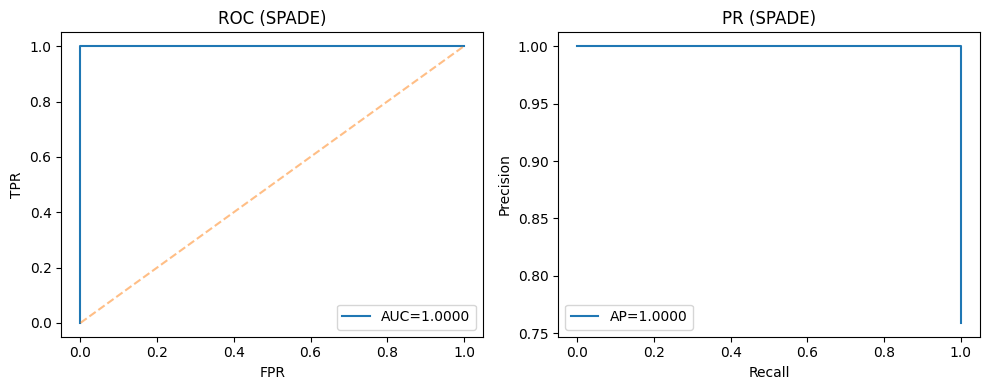

[SHOW] Top-6 anomaly candidates


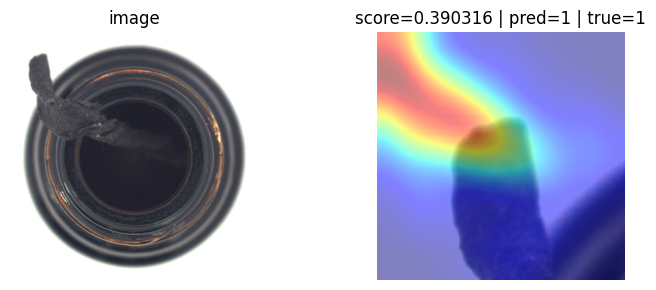

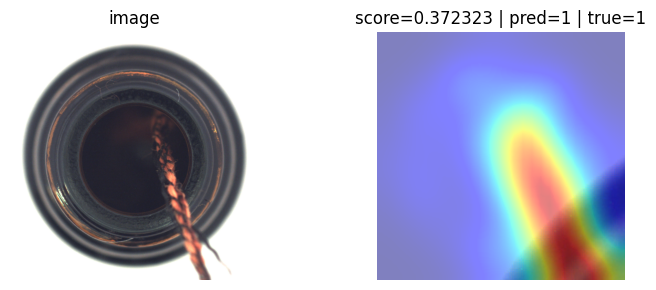

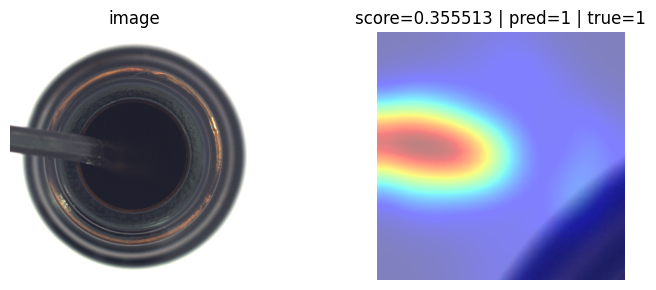

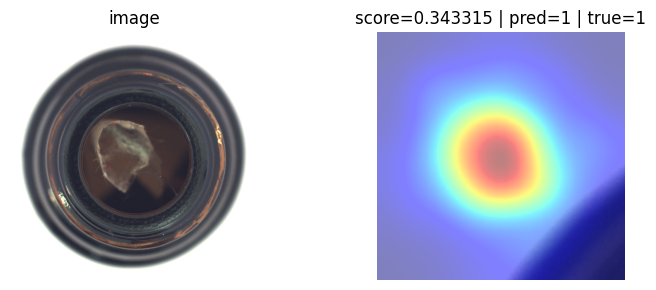

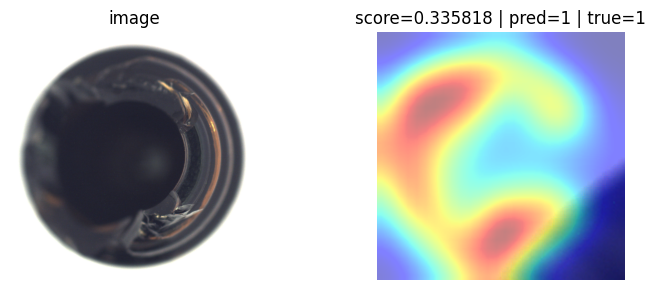

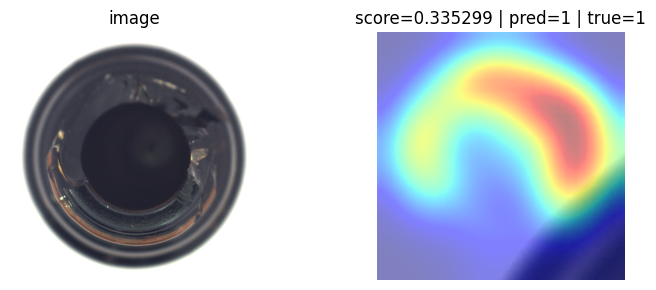

[CONF] TP=63 FP=0 FN=0 TN=20
[SAVED] ./out_spade/scores_bottle.npy, labels_bottle.npy


In [4]:
# ============================================================
# SPADE (Sub-Image Anomaly Detection) for MVTec AD on Colab
# - 同じ体裁：root自動検出→train/val/test→スコア/ROC→可視化→保存
# - 特徴: ResNet18のlayer2+layer3を多段特徴として使用
# - 近傍探索: sklearn NearestNeighbors (cosine, 1-NN)
# ============================================================

import os, glob, math, random, time, shutil
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc
from scipy.ndimage import gaussian_filter

# ---------------- Config ----------------
CLASS_NAME       = "bottle"     # ★必要に応じて変更（mvtec のサブクラス名）
IMG_SIZE         = 256
CROP_SIZE        = 224
BATCH            = 16
VAL_SPLIT        = 0.1          # train/good のうち val 用割合
FEAT_LAYERS      = ("layer2", "layer3")  # SPADE: multi-scale特徴
TOP_P            = 0.02         # 画像スコア＝上位p%平均
BLUR_KERNEL      = 4            # ヒートマップ平滑化 (0/None で無効)
MAX_TRAIN_DESCS  = 60000        # メモリ節約のためtrain記述子をランダム間引き
SAVE_DIR         = "./out_spade"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(SAVE_DIR, exist_ok=True)
torch.set_grad_enabled(False)
np.random.seed(0); random.seed(0); torch.manual_seed(0)

# --------------- Dataset utils ---------------
def _list_images_multi_ext(dirp):
    exts = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")
    files=[]
    for r,_,fs in os.walk(dirp):
        for f in fs:
            if os.path.splitext(f)[1].lower() in exts:
                files.append(os.path.join(r,f))
    return sorted(files)

def autodetect_root(class_name: str):
    # 候補ルート（PaDiMと同じ）
    cands_root = ["/content/mvtec", "/content/mvtec_anomaly_detection"]
    hits=[]
    for base in cands_root:
        if not os.path.isdir(base): continue
        p_train = os.path.join(base, class_name, "train", "good")
        p_test  = os.path.join(base, class_name, "test")
        if os.path.isdir(p_train) and os.path.isdir(p_test):
            hits.append(base)
    if not hits:
        # もう少し深く
        for base in ["/content"]:
            for p in glob.glob(os.path.join(base, "**", class_name, "train", "good"), recursive=True):
                root = p.split(f"/{class_name}/train/")[0]
                hits.append(root)
    if not hits:
        raise FileNotFoundError(f"Dataset class '{class_name}' not found under /content. "
                                "Please place MVTec AD and re-run.")
    # 複数見つかったら最短パスを採用
    hits = sorted(hits, key=lambda x: len(x))
    return hits[0]

def print_dataset_summary(root, cls):
    tg  = os.path.join(root, cls, "train", "good")
    ttg = os.path.join(root, cls, "test", "good")
    tdir= os.path.join(root, cls, "test")
    def _c(p): return len(_list_images_multi_ext(p)) if os.path.isdir(p) else 0
    # 異常タイプ一覧
    subs = []
    if os.path.isdir(tdir):
        subs = [d for d in os.listdir(tdir) if os.path.isdir(os.path.join(tdir,d)) and d!="good" and d!="ground_truth"]
    n_an = 0
    for d in subs:
        n_an += _c(os.path.join(tdir,d))
    print("[SUMMARY]", {"root":root, "class":cls, "train/good":_c(tg), "test/good":_c(ttg),
                       "test/anoms":n_an, "anomaly_types":subs})

# --------------- Datasets ---------------
_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=Image.BILINEAR),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])

class MVTecTrain(Dataset):
    def __init__(self, root, cls, val_split=0.1, is_val=False):
        base = os.path.join(root, cls, "train", "good")
        files = _list_images_multi_ext(base)
        assert len(files)>0, f"No train images in {base}"
        n_val = max(1, int(len(files)*val_split))
        self.files = files[:n_val] if is_val else files[n_val:]
        if is_val and len(self.files)==0: self.files = files[-n_val:]
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        return _tf(img), 0

class MVTecTest(Dataset):
    def __init__(self, root, cls):
        base = os.path.join(root, cls, "test")
        goods = _list_images_multi_ext(os.path.join(base,"good"))
        anoms = []
        types = []
        for d in os.listdir(base):
            p = os.path.join(base,d)
            if os.path.isdir(p) and d not in ["good","ground_truth"]:
                fs = _list_images_multi_ext(p)
                anoms.extend(fs); types.extend([d]*len(fs))
        self.files  = goods + anoms
        self.labels = [0]*len(goods) + [1]*len(anoms)
        self.types  = ["good"]*len(goods) + types
        assert len(self.files)>0, f"No test images in {base}"
        self.root = root; self.cls = cls
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        x   = _tf(img)
        y   = self.labels[i]
        return x, y, self.files[i], self.types[i]

# --------------- Feature Extractor (ResNet18 hooks) ---------------
class ResNetFPN(nn.Module):
    def __init__(self, layers=("layer2","layer3")):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.eval()
        for p in self.backbone.parameters(): p.requires_grad_(False)
        self.layers = layers
        self._feats = {}
        def hook(name):
            def fn(m, inp, out): self._feats[name] = out
            return fn
        self.backbone.layer2.register_forward_hook(hook("layer2"))
        self.backbone.layer3.register_forward_hook(hook("layer3"))
    def forward(self, x):
        _ = self.backbone(x)  # hooks fill self._feats
        feats = []
        if "layer2" in self.layers and "layer3" in self.layers:
            f2 = self._feats["layer2"]                 # (B,128,H2,W2)  ~ 28x28
            f3 = self._feats["layer3"]                 # (B,256,H3,W3)  ~ 14x14
            f3u = F.interpolate(f3, size=f2.shape[2:], mode="bilinear", align_corners=False)
            f   = torch.cat([f2, f3u], dim=1)          # (B,384,H2,W2)
            # L2 normalize along channel for cosine距離の安定化
            f = F.normalize(f, p=2, dim=1)
            feats.append(f)
        else:
            raise NotImplementedError
        return feats[0]

def feats_to_descriptors(fmap: torch.Tensor) -> torch.Tensor:
    # fmap: (B,C,H,W) -> (B, H*W, C)
    B,C,H,W = fmap.shape
    return fmap.permute(0,2,3,1).contiguous().view(B, H*W, C)

# --------------- Train: build memory bank (SPADE) ---------------
def build_memory(descr_list: List[torch.Tensor], max_keep=MAX_TRAIN_DESCS):
    # descr_list: [ (N_i, C) ] for each image (flatten済み)
    all_desc = torch.cat(descr_list, dim=0)  # (N_total, C)
    N = all_desc.shape[0]
    if N > max_keep:
        idx = torch.randperm(N)[:max_keep]
        all_desc = all_desc[idx]
    # to numpy (float32)
    mem = all_desc.cpu().numpy().astype(np.float32)
    return mem

# --------------- Score on batch ---------------
def spade_batch_scores(nn_index: NearestNeighbors, fmap: torch.Tensor, H0=CROP_SIZE, W0=CROP_SIZE):
    # fmap -> descriptors
    desc = feats_to_descriptors(fmap)     # (B, P, C)
    B, P, C = desc.shape
    x = desc.reshape(B*P, C).cpu().numpy().astype(np.float32)
    # 最近傍Cosine距離（1-NN）
    dists, _ = nn_index.kneighbors(x, n_neighbors=1, return_distance=True)
    dists = dists.reshape(B, P)           # (B,P)
    # 2D map
    h = w = int(math.sqrt(P))             # layer2 grid (28x28 when crop=224)
    amap = dists.reshape(B, h, w)
    # 平滑化 & アップサンプル
    if BLUR_KERNEL and BLUR_KERNEL>0:
        amap = np.stack([gaussian_filter(a, sigma=BLUR_KERNEL/2.0) for a in amap], axis=0)
    amap_up = torch.from_numpy(amap).unsqueeze(1).float()
    amap_up = F.interpolate(amap_up, size=(H0, W0), mode="bilinear", align_corners=False).squeeze(1).cpu().numpy()
    # 画像スコア = 上位p%平均
    flat = amap_up.reshape(B, -1)
    k = max(1, int(flat.shape[1]*TOP_P))
    im_scores = np.mean(np.partition(flat, -k, axis=1)[:, -k:], axis=1)
    return amap_up, im_scores

# --------------- Run ---------------
root = autodetect_root(CLASS_NAME)
print_dataset_summary(root, CLASS_NAME)

# DataLoaders
ds_tr = MVTecTrain(root, CLASS_NAME, val_split=VAL_SPLIT, is_val=False)
ds_va = MVTecTrain(root, CLASS_NAME, val_split=VAL_SPLIT, is_val=True)
ds_te = MVTecTest (root, CLASS_NAME)

dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print(f"[INFO] train={len(ds_tr)} | val={len(ds_va)} | test={len(ds_te)}")

# Feature backbone
backbone = ResNetFPN(FEAT_LAYERS).to(device).eval()

# ---- 1) メモリバンク作成（train/good）----
train_desc = []
for xb, _ in dl_tr:
    xb = xb.to(device)
    fmap = backbone(xb)                   # (B,384,h,w)
    desc = feats_to_descriptors(fmap).reshape(-1, fmap.shape[1])   # (B*P, C)
    train_desc.append(desc.detach().cpu())

MEM = build_memory(train_desc, max_keep=MAX_TRAIN_DESCS)  # (N_mem, C)
print(f"[MEM] descriptors: {MEM.shape}")

# NN index 構築（cosine）
nn_index = NearestNeighbors(n_neighbors=1, algorithm="brute", metric="cosine")
nn_index.fit(MEM)

# ---- 2) 閾値学習（val）----
val_scores = []
for xb, _ in dl_va:
    xb = xb.to(device)
    fmap = backbone(xb)
    amap, sc = spade_batch_scores(nn_index, fmap, H0=CROP_SIZE, W0=CROP_SIZE)
    val_scores.extend(sc.tolist())
val_scores = np.asarray(val_scores, dtype=np.float32)
tau = float(np.percentile(val_scores, 99.5))
print(f"[TAU] from val 99.5% → tau={tau:.6f}")

# ---- 3) test: 推論・評価 ----
all_scores, all_labels = [], []
all_amaps, all_paths = [], []
for xb, yb, paths, types in dl_te:
    xb = xb.to(device)
    fmap = backbone(xb)
    amap, sc = spade_batch_scores(nn_index, fmap, H0=CROP_SIZE, W0=CROP_SIZE)
    all_scores.extend(sc.tolist())
    all_labels.extend(yb.numpy().tolist())
    all_amaps.extend(list(amap))
    all_paths.extend(list(paths))

scores_np = np.asarray(all_scores, dtype=np.float32)
labels_np = np.asarray(all_labels, dtype=np.int32)

# 画像レベル ROC / PR
auroc_img = roc_auc_score(labels_np, scores_np)
prec, rec, _ = precision_recall_curve(labels_np, scores_np)
ap_img = average_precision_score(labels_np, scores_np)
print(f"[IMAGE] AUROC={auroc_img:.4f} | AP={ap_img:.4f}")

# 曲線表示
fpr, tpr, thr = roc_curve(labels_np, scores_np)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(fpr,tpr,label=f"AUC={auroc_img:.4f}"); plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (SPADE)"); plt.legend()
plt.subplot(1,2,2); plt.plot(rec,prec,label=f"AP={ap_img:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (SPADE)"); plt.legend()
plt.tight_layout(); plt.show()

# ---- 4) 可視化（Top異常／誤検出/見逃し）----
def imread_rgb(p):
    img = Image.open(p).convert("RGB")
    return np.array(img)

def show_overlay(img_rgb, amap, title):
    hm = (amap - amap.min())/(amap.max()-amap.min()+1e-8)
    plt.figure(figsize=(8,3))
    ax1 = plt.subplot(1,2,1); ax1.imshow(img_rgb); ax1.set_title("image"); ax1.axis("off")
    ax2 = plt.subplot(1,2,2); ax2.imshow(img_rgb); ax2.imshow(hm, cmap="jet", alpha=0.5); ax2.set_title(title); ax2.axis("off")
    plt.tight_layout(); plt.show()

# TopK by score
order = np.argsort(-scores_np)
TOPK  = min(6, len(order))
print(f"[SHOW] Top-{TOPK} anomaly candidates")
for r in range(TOPK):
    i = int(order[r])
    img = imread_rgb(all_paths[i])
    show_overlay(img, all_amaps[i], f"score={scores_np[i]:.6f} | pred={int(scores_np[i]>tau)} | true={labels_np[i]}")

# しきい値で混同行列＆誤検出/見逃しの例
preds = (scores_np > tau).astype(np.int32)
TP = np.where((preds==1)&(labels_np==1))[0]
FP = np.where((preds==1)&(labels_np==0))[0]
FN = np.where((preds==0)&(labels_np==1))[0]
print(f"[CONF] TP={len(TP)} FP={len(FP)} FN={len(FN)} TN={len(labels_np)-len(TP)-len(FP)-len(FN)}")

for name, idxs in [("False Positive", FP[:3]), ("False Negative", FN[:3])]:
    if len(idxs)==0: continue
    print(f"[SHOW] {name} examples")
    for i in idxs:
        img = imread_rgb(all_paths[i])
        show_overlay(img, all_amaps[i], f"{name} | score={scores_np[i]:.6f}")

# ---- 5) 保存（UNet/PaDiMと同じパス規約）----
np.save(os.path.join(SAVE_DIR, f"scores_{CLASS_NAME}.npy"), scores_np)
np.save(os.path.join(SAVE_DIR, f"labels_{CLASS_NAME}.npy"), labels_np)
print(f"[SAVED] {SAVE_DIR}/scores_{CLASS_NAME}.npy, labels_{CLASS_NAME}.npy")
